#Toxic Comment Classification 
##Identify and classify toxic online comments

Giulia Cataldo, Bianca Cattaneo, Jacopo Signò

Dataset : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data


## 3. BERT implementation with PyTorch

In [ ]:
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q 'lightning-flash[text]' --upgrade

     |████████████████████████████████| 5.8 MB 38.7 MB/s 
     |████████████████████████████████| 182 kB 102.1 MB/s 
     |████████████████████████████████| 7.6 MB 83.6 MB/s 
     |████████████████████████████████| 800 kB 32.2 MB/s 
     |████████████████████████████████| 512 kB 64.2 MB/s 
     |████████████████████████████████| 125 kB 71.5 MB/s 
     |████████████████████████████████| 1.1 MB 28.0 MB/s 
     |████████████████████████████████| 139 kB 68.1 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 452 kB 92.7 MB/s 
     |████████████████████████████████| 85 kB 5.8 MB/s 
     |████████████████████████████████| 1.3 MB 82.0 MB/s 
     |████████████████████████████████| 132 kB 74.2 MB/s 
     |████████████████████████████████| 212 kB 105.0 MB/s 
     |████████████████████████████████| 127 kB 99.4 MB/s 


## Importing the libraries 

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pyl
from torchmetrics import F1Score, Accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from torchmetrics.functional import accuracy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle 
import matplotlib as mpl
#from torchmetrics.classification import MultilabelAUROC
 
mpl.style.use('ggplot') 

In [ ]:
from torchmetrics.classification import AUROC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Loading the cleaned dataset

In [ ]:

with open('/content/drive/MyDrive/text_mex_project/data/new_dataset', 'rb') as f:
    df = pickle.load(f)

This data has been cleaned already. However, in this case we kept all the stopwords since these can be useful information for BERT.

In [ ]:
df.loc[1:5,:]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,total_classes,y
1,hey what is it talk what is it an exclusive gr...,1,0,0,0,0,0,0,1,"1,0,0,0,0,0"
2,bye don t look come or think of comming back t...,1,0,0,0,0,0,0,1,"1,0,0,0,0,0"
3,not at all you are making a straw man argument...,0,0,0,0,0,0,1,0,"0,0,0,0,0,0"
4,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1,0,3,"1,0,1,0,1,1"
5,fuck your filthy mother in the ass dry,1,0,1,0,1,0,0,3,"1,0,1,0,1,0"


In [ ]:
# combnations of classes with the lowest occurrence
print("Number of label combinations that appear only once: ",sum(df["y"].value_counts() == 1))

# number of unique combination of classes
print("Number of unique combination of classes:", df["y"].nunique())

# Removing all the rare combinations
df_filtered = df.groupby("y").filter(lambda x: len(x) > 1)
df_filtered.shape

df_filtered = df_filtered.reset_index(drop=True)

Number of label combinations that appear only once:  1
Number of unique combination of classes: 41


Splitting in train, validation and test datasets

In [ ]:
test_split = 0.4

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["y"],
)


# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# dropping usless columns
train_df.drop(['non_toxic',	'total_classes', 'y'], axis=1, inplace=True)
test_df.drop(['non_toxic',	'total_classes', 'y'], axis=1, inplace=True)
val_df.drop(['non_toxic',	'total_classes', 'y'], axis=1, inplace=True)


Number of rows in training set: 18239
Number of rows in validation set: 6080
Number of rows in test set: 6080


We convert all the 0's and 1's in numeric values

In [ ]:
cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate'] 
                                                                                        
for i in [train_df, test_df, val_df]:
  i[cols] = i[cols].apply(pd.to_numeric)

## BERT Tokenizer

In [ ]:
# Taking the base version of BERT
BERT_MODEL_NAME = "bert-base-cased"
# Downloading the tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

## Encoding mechanism 

Here we look at the encoding process on a single comment to clearly understand what is happening.

In [ ]:
# looking at a sample comment

LABEL_COLUMNS = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

sample_row = df.loc[44]
sample_comment = sample_row.comment_text #we extract the sentence 
sample_labels = sample_row[LABEL_COLUMNS] #we extract the label columns 

print(sample_comment)
print(sample_labels.to_dict())

windows phone upgradeability hi gregory i reverted your change on the windows phone article neither microsoft nor its partners have made any official statements on whether devices running windows phone will be upgradeable to windows phone the references given by another user are blogs that are relying on hearsay
{'toxic': '0', 'severe_toxic': '0', 'obscene': '0', 'threat': '0', 'insult': '0', 'identity_hate': '0'}


We use the tokenizer from BERT to encode the sample comment 

In [ ]:
# using the encode plus method that accepts more parameters
encoding = tokenizer.encode_plus(
    sample_comment,
    add_special_tokens = True, # special tokens required by BERT
    max_length = 250,
    return_token_type_ids = False,
    padding = 'max_length',
    return_tensors = 'pt' # returning results as tensors in pytorch format
)

The encoding variable is a dictionary with:
* Keys: ('input_ids', 'attention_mask')
* Values: the encoded tokens with padding and the corresponding attention masks

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
# looking at the input ids of the first tokens
encoding['input_ids'].squeeze()[:30]

tensor([  101,  3751,  2179, 12764,  6328, 20844,   176,  1874, 18791,  1183,
          178, 17464,  1240,  1849,  1113,  1103,  3751,  2179,  3342,  4534,
        17599,  7301,  4964,  4040,  1157,  6449,  1138,  1189,  1251,  2078])

In [ ]:
# looking at the input attention masks of the first tokens

encoding['attention_mask'].squeeze()[:30]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])

The *attention mask* allows to prevent the model from looking at padding tokens

Next step is converting input ids to actual tokens that BERT is using 

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze())[:21])

['[CLS]', 'windows', 'phone', 'upgrade', '##ability', 'hi', 'g', '##re', '##gor', '##y', 'i', 'reverted', 'your', 'change', 'on', 'the', 'windows', 'phone', 'article', 'neither', 'micro']


Creating a class for **encoding** purposes.
For each comment in the dataset that will be passed, it will return:

* the text of the comment;
* the padded encoding;
* the attention mask:
* the corresponding set of labels.


In [ ]:
# Padding size
MAX_TOKEN_COUNT = 250

In [ ]:
class ToxicCommentDataset(Dataset):

  def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 128):

    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    
    comment_text = data_row.comment_text
    labels = data_row[LABEL_COLUMNS] 
    
    encoding = self.tokenizer.encode_plus(
        comment_text,
        add_special_tokens = True,
        max_length = self.max_token_len,
        return_token_type_ids = False,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    ) #encoding return tuple(input_ids, attention mask)

    return dict(
        comment_text = comment_text,
        input_ids = encoding['input_ids'].flatten(), 
        attention_mask = encoding['attention_mask'].flatten(),
        labels = torch.FloatTensor(labels), #converting to float tensors sequences of 0's and 1's that represent labels
    )



Passing the train_dataset to the ToxicCommentDataset class

In [ ]:
train_dataset = ToxicCommentDataset(train_df, tokenizer, max_token_len = MAX_TOKEN_COUNT)

We load the **bert-base-cased** from hugging face 

In [ ]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict = True)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Creating a data module that extends from Python Lightning data module.


A datamodule is a shareable, reusable class that encapsulates all the steps needed to process data
A datamodule encapsulates the five steps involved in data processing in PyTorch:
* Download / tokenize / process.
* Load inside Dataset.
* Apply transforms (rotate, tokenize, etc…).
* Wrap inside a DataLoader (combines a dataset and a sampler, and provides an iterable over the given dataset).

In [ ]:
class ToxicCommentDataModule(pyl.LightningDataModule):
  def __init__(self, train_df, val_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  
  def setup(self, stage=None): # this creates datasets from train_df, val_df and test_df
    
    self.train_dataset = ToxicCommentDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
      
    self.val_dataset = ToxicCommentDataset(
      self.val_df,
      self.tokenizer,
      self.max_token_len
    )
  
  
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2 
    )
  
  def val_dataloader(self): 
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  

# ToxicCommentDataModule encapsulates all data loading logic and returns the necessary data loaders

In [ ]:
N_EPOCHS = 10 
BATCH_SIZE = 12

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer = tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## The Model

Our model will use a pre-trained BertModel and a linear layer with a sigmdoid activation function to convert the BERT representation to a multi-label classification task. This layer gets the output of the BERT model and outputs the probability of belonging to each class.

In [ ]:
class ToxicCommentTagger(pyl.LightningModule):
  
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # dense layer for classification task    
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
   

  # forward() defines our prediction/inference actions

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)# this will give us an output for evrey single token we pass 
    output = self.classifier(output.pooler_output)
    
    output = torch.sigmoid(output) # sigmoid step for multilayer classification 
    loss = 0
    if labels is not None: #if labels is None it means that we are doing the predictions 
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels) 
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss   
  
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    
    for i, name in enumerate(LABEL_COLUMNS):
      auroc = AUROC(task="binary")
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(   
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    
  # The job of a scheduler is to change the learning rate of the optimizer during training.
  # starting with higher lr and decreasing it as we approach tha optimal solution
  # This might lead to better performance of our model. We’ll use the get_linear_schedule_with_warmup.

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )


## Training the model

Configuring the model's parameters 

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Here we define a ModelCheckpoint object that we'll use to save the results that we obtain by training the model. 

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath= F"/content/drive/MyDrive/text_mex_project/data/checkpoints",
  filename= "best-checkpoint",
  save_top_k=1,
  verbose = True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
# Log the progress in TensorBoard
logger = TensorBoardLogger(save_dir = "/content/drive/MyDrive/text_mex_project/data", name = "toxic-comments")

In [ ]:
# And early stopping triggers when the loss hasn’t improved for the last 2 epochs:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

Here we set the trainer, that will use to fit the model 

In [ ]:
trainer = pyl.Trainer(
  logger=logger,
  callbacks = [early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  accelerator='gpu', 
  devices=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


We train the model 

In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1520: 'val_loss' reached 0.21503 (best 0.21503), saving model to '/content/drive/.shortcut-targets-by-id/1w-fOCOdq-yk4wyhyhVEdvkuDFN3x1GFJ/text_mex_project/data/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 3040: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 4560: 'val_loss' reached 0.19069 (best 0.19069), saving model to '/content/drive/.shortcut-targets-by-id/1w-fOCOdq-yk4wyhyhVEdvkuDFN3x1GFJ/text_mex_project/data/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 6080: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 7600: 'val_loss' was not in top 1


## Predictions

We now load the best version of our model, that we preaviously save thanks to the Checkpoint, and we use them to compute predictions.

In [ ]:
# Let’s load the best version (according to the validation loss) of our model
trained_model = ToxicCommentTagger.load_from_checkpoint(
  "/content/drive/MyDrive/text_mex_project/data/checkpoints/best-checkpoint.ckpt",
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We put our model into “eval” mode, and we’re ready to make some predictions. Here’s the prediction on a sample (totally fictional) comment.
We reduce the noise of the predictions by thresholding them. We’ll take only tag predictions above (or equal) to the threshold.

We perform prediction on a made up comment in order to evaluate the generalization properties of our model

In [ ]:
THRESHOLD = 0.55
test_comment = "I'll you, you pig'"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

toxic: 0.9853352308273315
obscene: 0.6579892039299011
threat: 0.7978821992874146
insult: 0.7387099862098694


We use our model to perform prediction on the test dataset.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

test_dataset = ToxicCommentDataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []
for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

  0%|          | 0/6080 [00:00<?, ?it/s]

In [ ]:
labels = torch.stack(labels)
predictions = torch.stack(predictions)

In [ ]:
labels = labels.to(device)
predictions = predictions.to(device)

After storing the predictions, we compare them with the assigned labels to compute the accuracy.

In [ ]:
from torchmetrics.functional import accuracy
accuracy(predictions, labels, 'binary', 0.5)


tensor(0.9351, device='cuda:0')

In [ ]:
predictions = predictions.cpu()
labels = labels.cpu()

We compute the **classification report** in order to have a better picture of the overall performance of the model.

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

               precision    recall  f1-score   support

        toxic       0.92      0.98      0.95      4220
 severe_toxic       0.59      0.11      0.19       387
      obscene       0.90      0.87      0.88      2389
       threat       0.75      0.59      0.66       131
       insult       0.86      0.79      0.82      2204
identity_hate       0.86      0.55      0.67       374

    micro avg       0.89      0.85      0.87      9705
    macro avg       0.81      0.65      0.70      9705
 weighted avg       0.88      0.85      0.86      9705
  samples avg       0.65      0.63      0.63      9705



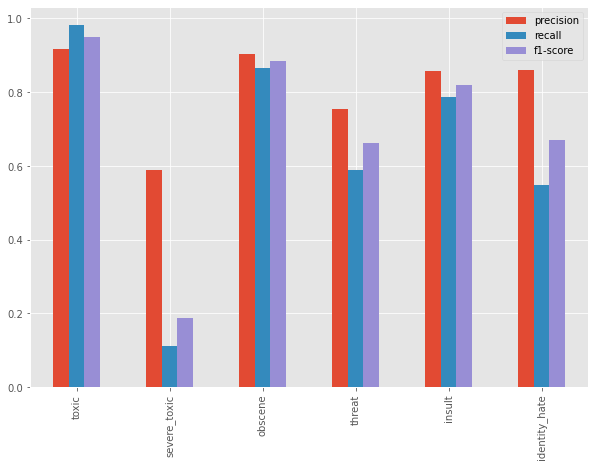

In [ ]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

report1 = classification_report(y_true, 
                                y_pred, digits=2,
                                zero_division = 0,
                                output_dict=True)
  
df_ = pd.DataFrame(report1)
df_.rename(columns={'0': 'toxic', '1': 'severe_toxic', '2': 'obscene', '3': 'threat', '4': 'insult', '5': 'identity_hate'}, inplace=True)
df_.iloc[:3, :6].T.plot(kind='bar', figsize=(10, 7))
plt.show()

##Model comparison 

Let's now compare the results that we obtained from the 2 diffents approaches we tried.

###Accuracy 

With both the BLST model and the BERT model we reached an **accuracy** ≃ 95%. However, since our data is very umbalanced, accuracy is not a very relevant metric to assess the performance of the models. Much more interesting measures are the **Precision** and **Recall**.

## Pecision, Recall and F1 scores



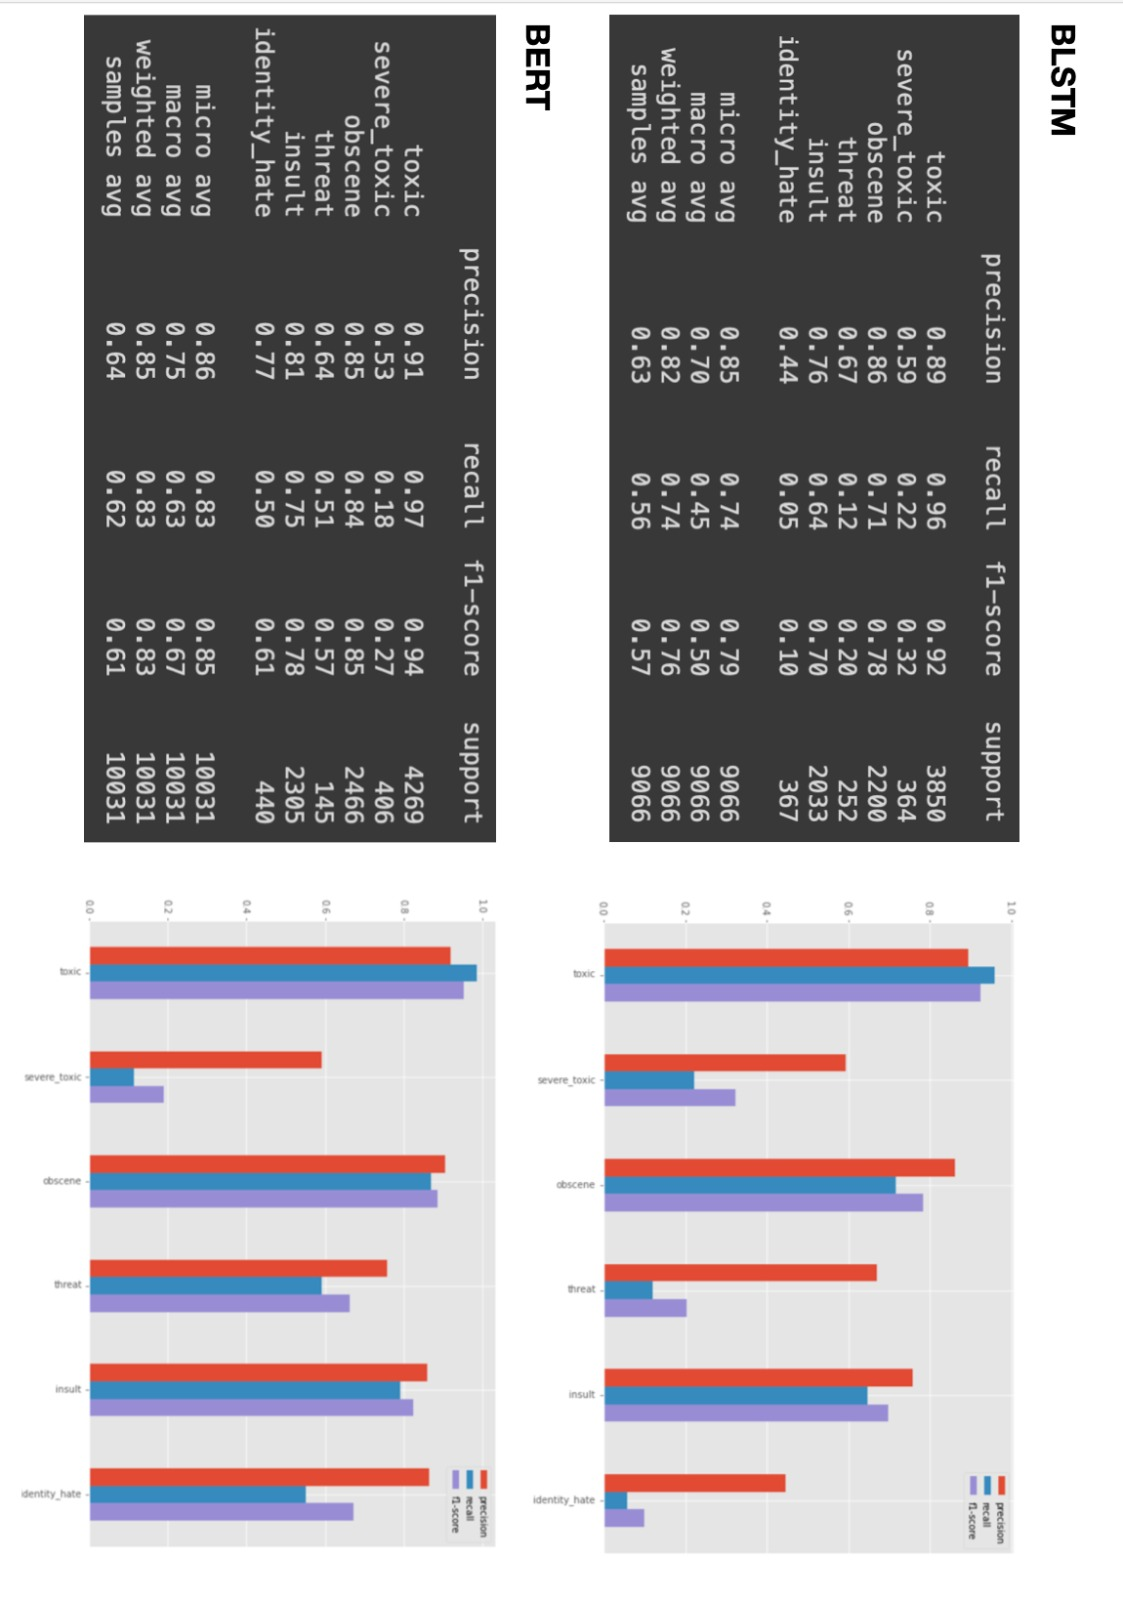

As we can see, and as we expected, with the BERT model we achive much better result. In general we have higher precision, recall and f1-score for all the categories, but most importantly we can see how BERT successfully manages to predict even the less represented classes such as threat and identity hate, although it's still struggling with sever toxic.